In [1]:
import numpy as np
import scipy
from scipy import integrate
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import time
import seaborn as sns


In [2]:
def adjacency_matrix(N : int, spectral_radius : float = 0.9, density : float = 0.02):
    rng = np.random.default_rng(0) # Initialize the numpy random number generator
    current_time = time.time_ns()
    M = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            M[i,j] = rng.uniform(0, 1.0) if rng.uniform(0.0, 1.0) < density else 0.0
    elapsed_time = time.time_ns() - current_time 
    print("> First construction [time in s]: ", elapsed_time/1.e9)
    
    current_time = time.time_ns()
    current_spectral_radius = np.abs(np.linalg.eigvals(M)).max()
    elapsed_time = time.time_ns() - current_time 
    print("> Spectral radius computation [time in s]: ", elapsed_time/1.e9)

    M *= spectral_radius / current_spectral_radius
    return M

In [3]:
def input_weights_lu2018(N : int, m : int):
    rng = np.random.default_rng(1)
    W_in = np.zeros((N, m))
    for i in range(N):
        W_in[i,rng.choice(m)] = rng.uniform(-1.0, 1.0)
    return W_in

def input_weights_zhang2021(N : int, m : int):
    rng = np.random.default_rng(1)
    W_in = np.zeros((N, m))
    for i in range(N):
        for j in range(m):
            W_in[i,j] = rng.uniform(-1.0, 1.0)
    return W_in

In [4]:
def bias_vector(N : int):
    rng = np.random.default_rng(2) # Initialize the numpy random number generator
    bias = np.zeros(N)
    for i in range(N):
        bias[i] = rng.uniform(-1.0, 1.0)
    return bias

In [5]:
def double_pendulum_dynamics(t, w):
    u =  np.zeros(4)
    theta1, omega1, theta2, omega2 = w
    u[0] = omega1
    u[1] = (9*np.cos(theta1-theta2)*np.sin(theta1-theta2)*omega1**2+6*np.sin(theta1-theta2)*omega2**2 + 18*np.sin(theta1)-9*np.cos(theta1-theta2)*np.sin(theta2))/(9*np.cos(theta1-theta2)**2-16)
    u[2] = omega2
    u[3] = (24*np.sin(theta1-theta2)*omega1**2+9*np.cos(theta1-theta2)*np.sin(theta1-theta2)*omega2**2+27*np.cos(theta1-theta2)*np.sin(theta1)-24*np.sin(theta2))/(16-9*np.cos(theta1-theta2)**2)
    return u


In [6]:
class ParameterAwareDiscreteReservoir:

    def __init__(self, N : int, m: int, gamma: float, sigma : float, spectral_radius : float = 0.9, density : float = 0.02):

        # Reservoir dimension
        self.size = N
        # Dynamical system dimension
        self.input_dim = m

        # Reservoir dynamics parameters
        self.gamma = gamma  
        self.sigma = sigma 
        
        # Construction of the adjacency matrix M following (Lu et al. 2018) and (Zhang et al. 2021)
        current_time = time.time_ns()
        self.M = adjacency_matrix(N, spectral_radius, density)
        elapsed_time = time.time_ns() - current_time
        print("Adjacency matrix construction [time in s]: ", elapsed_time/1.e9)

        # Construction of the matrix of input weights W_in following (Zhang et al. 2021)
        self.W_in = input_weights_zhang2021(N, m)

        # Construction of the bias vector 
        self.bias = bias_vector(N)

        # Set the internal state to be uninitialized
        self.r = None
        self.learned_reservoir_data = None
        self.learned_input_data = None
        self.W_out = None
        self.predicted_r = None
        self.prediction = None

    """
    forget
    """
    def forget(self):
        self.r = None
        self.learned_reservoir_data = None
        self.learned_input_data = None
        self.W_out = None
        self.predicted_r = None
        self.prediction = None


    """
    learn_data

    input_data: an array whose j-th row is the input to the reservoir at time j; the matrix should have shape (*, m)
    start_time: the starting time for integrating the dynamics
    start_learning_time: the starting time for the learning phase
    end_time: the ending time for the learning phase
    initial_r: an initial state for the reservoir
    beta: bias parameter

    This method appends the evolution of the reservoir to `self.learned_reservoir_data` and the corresponding input data to `self.learned_input_data`
    """
    def learn_data(self, input_data : np.ndarray, start_time : int, start_learning_time : int, end_time : int, initial_r: np.ndarray, beta : float):
        nrows, m = np.shape(input_data)
        assert(m == self.input_dim), "`input_data` has the wrong shape"
        assert(0 <= start_time <= start_learning_time <= end_time <= nrows), "time-range constraints are not satisfied"
        def learning_reservoir_dynamics(j : int, w : np.ndarray):
            return (1.0 - self.gamma) * w + self.gamma * np.tanh(self.M @ w + self.sigma * self.W_in @ input_data[j] + self.sigma * beta * self.bias)

        w = np.copy(initial_r)
        for j in range(start_time, start_learning_time):
            w = learning_reservoir_dynamics(j, w)

        learned_reservoir_data = np.zeros((end_time-start_learning_time, self.size))
        # We have
        #   input_data[start_learning_time], input_data[start_learning_time+1], ....
        # which should be aligned with
        #   learned_reservoir_data[0], learned_reservoir_data[1], ...
        # When we call `w = learning_reservoir_dynamics(j, w)` then the new w is associated to input_data[j+1]
        # and the old w is associated to input_data[j].
        # This means that for j = start_learning_data we want to make learned_reservoir_dynamics[0] to be the old w,
        # that is, we first need to make the assignment and then apply the learning map.
        for j in range(start_learning_time, end_time):
            learned_reservoir_data[j-start_learning_time,:] = w
            w = learning_reservoir_dynamics(j, w)

        if self.learned_reservoir_data is None:
            self.learned_reservoir_data = np.copy(learned_reservoir_data)
        else:
            self.learned_reservoir_data = np.vstack([self.learned_reservoir_data, np.copy(learned_reservoir_data)])

        if self.learned_input_data is None:
            self.learned_input_data = input_data[start_learning_time:end_time]
        else:
            self.learned_input_data = np.vstack([self.learned_input_data, input_data[start_learning_time:end_time]])



    """
    train

    alpha: the regularization parameter for Ridge regression

    This method sets `self.W_out`.
    """
    def train(self, alpha : float):
        assert(self.learned_input_data is not None), "No learning has been done; first use `learn_data`."

        X = np.copy(self.learned_reservoir_data)
        y = np.copy(self.learned_input_data)

        # Ridge regression
        clf = Ridge(alpha=alpha, fit_intercept=False, tol=1.e-12, solver="svd")
        clf.fit(X, y)

        self.W_out = np.copy(clf.coef_)


    """
    evolved_predicting_reservoir

    For a trained reservoir this method will autonomously evolve the reservoir starting from
    its current state and saves the integration result to `self.predicted_solution`.

    initial_data: the initial state of the system we try to predict
    initial_r: corresponding initial reservoir state
    for_time: for how much time to evolve the reservoir
    beta: bias parameter
    """
    def evolve_predicting_reservoir(self, initial_data: np.ndarray, initial_r: np.ndarray, conv_time: int, for_time : int, beta: float):
        assert(self.W_out is not None), "The reservoir must first be trained"
        mat = self. M + self.sigma * self.W_in @ self.W_out
        def predicting_reservoir_dynamics(w : np.ndarray):
            return (1.0 - self.gamma) * w + self.gamma * np.tanh(mat @ w + self.sigma * beta * self.bias)
        # perform two steps of learning
        w = np.copy(initial_r)
        for i in range(conv_time):
            w = (1.0 - self.gamma) * w + self.gamma * np.tanh(self.M @ w + self.sigma * self.W_in @ initial_data + self.sigma * beta * self.bias)
        # evolve the predicting reservoir
        self.predicted_r = np.zeros((for_time, self.size))
        for i in range(for_time):
            self.predicted_r[i,:] = w
            w = predicting_reservoir_dynamics(w)
        self.prediction = np.zeros((for_time, self.input_dim))
        self.prediction[0,:] = initial_data
        for i in range(1, for_time):
            self.prediction[i,:] = self.reservoir_state_output(self.predicted_r[i-1,:])




    """
    reservoir_state_output

    For an internal state `r` this method returns the corresponding output.
    """
    def reservoir_state_output(self, r):
        assert(self.W_out is not None), "The reservoir must first be trained"
        return self.W_out @ r


In [7]:
p=parameters_zhang2021_parameter_aware = {"N": 1000, "adjacency_matrix_density": 0.9745, "spectral_radius": 1.1273, "alpha": 0.6397, "sigma": 0.9444, "lambda": 0.019798}


In [9]:
wout_set=[]
for i in range(21):
    p1=0.1*i-1
    for j in range(21):
        p2=0.1*j-1
        dp_sol1 = scipy.integrate.solve_ivp(double_pendulum_dynamics, [0.0, 2500.0], [0.6, 0.0, p1, p2], "DOP853", dense_output=True)
        dp_data1 = np.transpose(dp_sol1.sol(np.linspace(0.0, 2000.0, 10000)))
        rsv1 =  ParameterAwareDiscreteReservoir(p["N"], 4,p["alpha"] , p["sigma"], p["spectral_radius"] , p["adjacency_matrix_density"])
      #print("Learning")
        np.random.seed(4)
        rsv1.learn_data(dp_data1, 0, 100, 2100, np.random.uniform(-0.1, 0.1, p["N"]), 0)
        
        #print("Training")
        rsv1.train(p["lambda"])
        #print("Predicting")
        #rsv1.integrate_predicting_reservoir(1000)
        wout_set.append(rsv1.W_out)
        print(j)

> First construction [time in s]:  3.642655
> Spectral radius computation [time in s]:  0.418618
Adjacency matrix construction [time in s]:  4.062819
0
> First construction [time in s]:  3.742841
> Spectral radius computation [time in s]:  0.418932
Adjacency matrix construction [time in s]:  4.162939
1
> First construction [time in s]:  3.93539
> Spectral radius computation [time in s]:  0.436505
Adjacency matrix construction [time in s]:  4.372912
2
> First construction [time in s]:  3.929164
> Spectral radius computation [time in s]:  0.503935
Adjacency matrix construction [time in s]:  4.434344
3
> First construction [time in s]:  3.819733
> Spectral radius computation [time in s]:  0.452475
Adjacency matrix construction [time in s]:  4.273242
4
> First construction [time in s]:  4.09007
> Spectral radius computation [time in s]:  0.579728
Adjacency matrix construction [time in s]:  4.670961
5
> First construction [time in s]:  3.746017
> Spectral radius computation [time in s]:  0.

11
> First construction [time in s]:  4.024203
> Spectral radius computation [time in s]:  0.557828
Adjacency matrix construction [time in s]:  4.583308
12
> First construction [time in s]:  3.804893
> Spectral radius computation [time in s]:  0.555888
Adjacency matrix construction [time in s]:  4.362531
13
> First construction [time in s]:  4.073754
> Spectral radius computation [time in s]:  0.433334
Adjacency matrix construction [time in s]:  4.508134
14
> First construction [time in s]:  3.736547
> Spectral radius computation [time in s]:  0.557943
Adjacency matrix construction [time in s]:  4.295667
15
> First construction [time in s]:  3.889269
> Spectral radius computation [time in s]:  0.462205
Adjacency matrix construction [time in s]:  4.352576
16
> First construction [time in s]:  3.908519
> Spectral radius computation [time in s]:  0.519553
Adjacency matrix construction [time in s]:  4.429251
17
> First construction [time in s]:  3.706588
> Spectral radius computation [time

2
> First construction [time in s]:  4.040591
> Spectral radius computation [time in s]:  0.519069
Adjacency matrix construction [time in s]:  4.560625
3
> First construction [time in s]:  3.895861
> Spectral radius computation [time in s]:  0.423518
Adjacency matrix construction [time in s]:  4.320617
4
> First construction [time in s]:  3.951801
> Spectral radius computation [time in s]:  0.438299
Adjacency matrix construction [time in s]:  4.391106
5
> First construction [time in s]:  3.942811
> Spectral radius computation [time in s]:  0.405948
Adjacency matrix construction [time in s]:  4.349768
6
> First construction [time in s]:  4.13729
> Spectral radius computation [time in s]:  0.416662
Adjacency matrix construction [time in s]:  4.555197
7
> First construction [time in s]:  3.805857
> Spectral radius computation [time in s]:  0.609728
Adjacency matrix construction [time in s]:  4.416913
8
> First construction [time in s]:  3.9801
> Spectral radius computation [time in s]:  0

14
> First construction [time in s]:  3.741662
> Spectral radius computation [time in s]:  0.40765
Adjacency matrix construction [time in s]:  4.150362
15
> First construction [time in s]:  3.810896
> Spectral radius computation [time in s]:  0.413877
Adjacency matrix construction [time in s]:  4.225818
16
> First construction [time in s]:  3.923293
> Spectral radius computation [time in s]:  0.470474
Adjacency matrix construction [time in s]:  4.39486
17
> First construction [time in s]:  3.731449
> Spectral radius computation [time in s]:  0.418191
Adjacency matrix construction [time in s]:  4.150685
18
> First construction [time in s]:  3.798864
> Spectral radius computation [time in s]:  0.42794
Adjacency matrix construction [time in s]:  4.227823
19
> First construction [time in s]:  3.778657
> Spectral radius computation [time in s]:  0.451256
Adjacency matrix construction [time in s]:  4.23122
20
> First construction [time in s]:  3.716834
> Spectral radius computation [time in 

5
> First construction [time in s]:  3.687068
> Spectral radius computation [time in s]:  0.41302
Adjacency matrix construction [time in s]:  4.101291
6
> First construction [time in s]:  3.689222
> Spectral radius computation [time in s]:  0.421024
Adjacency matrix construction [time in s]:  4.111296
7
> First construction [time in s]:  3.68389
> Spectral radius computation [time in s]:  0.412804
Adjacency matrix construction [time in s]:  4.097628
8
> First construction [time in s]:  3.694814
> Spectral radius computation [time in s]:  0.497851
Adjacency matrix construction [time in s]:  4.193969
9
> First construction [time in s]:  3.680379
> Spectral radius computation [time in s]:  0.415759
Adjacency matrix construction [time in s]:  4.097338
10
> First construction [time in s]:  3.676406
> Spectral radius computation [time in s]:  0.412927
Adjacency matrix construction [time in s]:  4.090296
11
> First construction [time in s]:  3.702717
> Spectral radius computation [time in s]:

17
> First construction [time in s]:  3.994696
> Spectral radius computation [time in s]:  0.481653
Adjacency matrix construction [time in s]:  4.477673
18
> First construction [time in s]:  3.878726
> Spectral radius computation [time in s]:  0.457921
Adjacency matrix construction [time in s]:  4.337864
19
> First construction [time in s]:  3.795635
> Spectral radius computation [time in s]:  0.413008
Adjacency matrix construction [time in s]:  4.20954
20
> First construction [time in s]:  4.062035
> Spectral radius computation [time in s]:  0.513479
Adjacency matrix construction [time in s]:  4.576605
0
> First construction [time in s]:  4.318322
> Spectral radius computation [time in s]:  0.677339
Adjacency matrix construction [time in s]:  5.000134
1
> First construction [time in s]:  3.759711
> Spectral radius computation [time in s]:  0.430698
Adjacency matrix construction [time in s]:  4.191489
2
> First construction [time in s]:  3.734711
> Spectral radius computation [time in 

8
> First construction [time in s]:  3.683538
> Spectral radius computation [time in s]:  0.406592
Adjacency matrix construction [time in s]:  4.091066
9
> First construction [time in s]:  3.653092
> Spectral radius computation [time in s]:  0.410326
Adjacency matrix construction [time in s]:  4.064417
10
> First construction [time in s]:  3.685762
> Spectral radius computation [time in s]:  0.407718
Adjacency matrix construction [time in s]:  4.094515
11
> First construction [time in s]:  3.822025
> Spectral radius computation [time in s]:  0.408008
Adjacency matrix construction [time in s]:  4.231512
12
> First construction [time in s]:  3.72468
> Spectral radius computation [time in s]:  0.407722
Adjacency matrix construction [time in s]:  4.133298
13
> First construction [time in s]:  3.670336
> Spectral radius computation [time in s]:  0.40563
Adjacency matrix construction [time in s]:  4.076864
14
> First construction [time in s]:  3.669075
> Spectral radius computation [time in 

20
> First construction [time in s]:  3.727105
> Spectral radius computation [time in s]:  0.407023
Adjacency matrix construction [time in s]:  4.135336
0
> First construction [time in s]:  3.681196
> Spectral radius computation [time in s]:  0.396866
Adjacency matrix construction [time in s]:  4.078923
1
> First construction [time in s]:  3.669079
> Spectral radius computation [time in s]:  0.407939
Adjacency matrix construction [time in s]:  4.077941
2
> First construction [time in s]:  3.727789
> Spectral radius computation [time in s]:  0.405389
Adjacency matrix construction [time in s]:  4.134105
3
> First construction [time in s]:  3.720652
> Spectral radius computation [time in s]:  0.413944
Adjacency matrix construction [time in s]:  4.135548
4
> First construction [time in s]:  3.653059
> Spectral radius computation [time in s]:  0.408373
Adjacency matrix construction [time in s]:  4.062576
5
> First construction [time in s]:  3.855754
> Spectral radius computation [time in s]

11
> First construction [time in s]:  3.69142
> Spectral radius computation [time in s]:  0.406
Adjacency matrix construction [time in s]:  4.098404
12
> First construction [time in s]:  3.67982
> Spectral radius computation [time in s]:  0.473155
Adjacency matrix construction [time in s]:  4.153909
13
> First construction [time in s]:  3.709251
> Spectral radius computation [time in s]:  0.402973
Adjacency matrix construction [time in s]:  4.113205
14
> First construction [time in s]:  3.665435
> Spectral radius computation [time in s]:  0.409027
Adjacency matrix construction [time in s]:  4.075464
15
> First construction [time in s]:  3.704362
> Spectral radius computation [time in s]:  0.404291
Adjacency matrix construction [time in s]:  4.109548
16
> First construction [time in s]:  3.723624
> Spectral radius computation [time in s]:  0.456948
Adjacency matrix construction [time in s]:  4.181492
17
> First construction [time in s]:  3.66633
> Spectral radius computation [time in s]

In [11]:
np.array(wout_set).shape

(441, 4, 1000)

In [12]:
ws=np.array(wout_set).reshape(21,21,4,1000)

predict :1.1 -0.51

In [27]:
z_pre = []
for i in range(4):
    for j in range(1000):
        w = []
        for m in range(21):
            for n in range(21):
                w.append(ws[m,n][i,j])
        warray = np.array(w).reshape(21,21)
        theta = np.mgrid[-1:1:21j]
        omega = np.mgrid[-1:1:21j]
        interp_spline = scipy.interpolate.RectBivariateSpline(theta, omega, warray)
        z = interp_spline(1.1, -0.51)
        z_pre.append(z.tolist()[0][0])
z_prepre = np.array(z_pre).reshape(4,1000)

In [28]:
z_prepre 

array([[-0.00537669, -0.00213761, -0.00412844, ...,  0.00136833,
        -0.00701457, -0.00527201],
       [-0.02819009,  0.00386634, -0.03594391, ...,  0.01270325,
         0.01760034,  0.00141322],
       [ 0.00149814,  0.00345935,  0.02119446, ..., -0.00448196,
        -0.01177624, -0.00109843],
       [ 0.06565501, -0.00939668,  0.07633089, ..., -0.01534198,
        -0.02707356,  0.0038974 ]])

In [29]:
dp_sol = scipy.integrate.solve_ivp(double_pendulum_dynamics, [0.0, 2500.0], [0.6, 0.0, 1.1, -0.51], "DOP853", dense_output=True)
dp_data = np.transpose(dp_sol.sol(np.linspace(0.0, 2000.0, 10000)))
rsv = ParameterAwareDiscreteReservoir(p["N"], 4, p["alpha"], p["sigma"], p["spectral_radius"], p["adjacency_matrix_density"])
#np.random.seed(4)
#print("Learning")
#rsv.integrate_learning_reservoir(dp_data, 0, 100, 2100, np.random.uniform(-0.1, -0.1, p["N"]))
        #print("Training")
#rsv.train(dp_data, 100, 2100, p["lambda"])
        #print("Predicting")
#rsv.integrate_predicting_reservoir(1000)

> First construction [time in s]:  3.942399
> Spectral radius computation [time in s]:  0.454641
Adjacency matrix construction [time in s]:  4.398352


In [30]:
rsv.W_out = z_prepre

In [31]:
rsv.W_out.shape

(4, 1000)

In [32]:

rsv.evolve_predicting_reservoir([0.6,0,1.1,-0.51], np.random.uniform(-0.1, 0.1, p["N"]),4,400, 0)
dp_pred_one = np.copy(rsv.prediction)


In [36]:
dp_pred_one.shape

(400, 4)

In [37]:
dp_data.shape

(10000, 4)

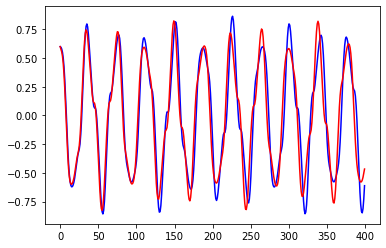

In [39]:
time_range = np.arange(0,400)
idx = 0
plt.plot(time_range, dp_data[time_range,idx], "blue")
#predict_data = [rsv.prediction(j)[idx] for j in time_range]
plt.plot(time_range,dp_pred_one[:,idx], "red")

predict: 0.05, 0.74

In [40]:
z_pre = []
for i in range(4):
    for j in range(1000):
        w = []
        for m in range(21):
            for n in range(21):
                w.append(ws[m,n][i,j])
        warray = np.array(w).reshape(21,21)
        theta = np.mgrid[-1:1:21j]
        omega = np.mgrid[-1:1:21j]
        interp_spline = scipy.interpolate.RectBivariateSpline(theta, omega, warray)
        z = interp_spline(1.1, -0.51)
        z_pre.append(z.tolist()[0][0])
z_prepre = np.array(z_pre).reshape(4,1000)
dp_sol = scipy.integrate.solve_ivp(double_pendulum_dynamics, [0.0, 2500.0], [0.6, 0.0, 0.05, 0.74], "DOP853", dense_output=True)
dp_data = np.transpose(dp_sol.sol(np.linspace(0.0, 2000.0, 10000)))
rsv = ParameterAwareDiscreteReservoir(p["N"], 4, p["alpha"], p["sigma"], p["spectral_radius"], p["adjacency_matrix_density"])
rsv.W_out = z_prepre

> First construction [time in s]:  4.027095
> Spectral radius computation [time in s]:  0.679574
Adjacency matrix construction [time in s]:  4.70905


In [41]:
rsv.evolve_predicting_reservoir([0.6,0,0.05,0.74], np.random.uniform(-0.1, 0.1, p["N"]),4,400, 0)
dp_pred_one = np.copy(rsv.prediction)


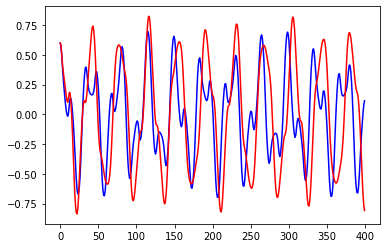

In [42]:
time_range = np.arange(0,400)
idx = 0
plt.plot(time_range, dp_data[time_range,idx], "blue")
#predict_data = [rsv.prediction(j)[idx] for j in time_range]
plt.plot(time_range,dp_pred_one[:,idx], "red")

predict 0.27 -0.67

In [43]:
z_pre = []
for i in range(4):
    for j in range(1000):
        w = []
        for m in range(21):
            for n in range(21):
                w.append(ws[m,n][i,j])
        warray = np.array(w).reshape(21,21)
        theta = np.mgrid[-1:1:21j]
        omega = np.mgrid[-1:1:21j]
        interp_spline = scipy.interpolate.RectBivariateSpline(theta, omega, warray)
        z = interp_spline(1.1, -0.51)
        z_pre.append(z.tolist()[0][0])
z_prepre = np.array(z_pre).reshape(4,1000)
dp_sol = scipy.integrate.solve_ivp(double_pendulum_dynamics, [0.0, 2500.0], [0.6, 0.0, 0.27, -0.67], "DOP853", dense_output=True)
dp_data = np.transpose(dp_sol.sol(np.linspace(0.0, 2000.0, 10000)))
rsv = ParameterAwareDiscreteReservoir(p["N"], 4, p["alpha"], p["sigma"], p["spectral_radius"], p["adjacency_matrix_density"])
rsv.W_out = z_prepre

> First construction [time in s]:  4.038323
> Spectral radius computation [time in s]:  0.465757
Adjacency matrix construction [time in s]:  4.50587


In [44]:
rsv.evolve_predicting_reservoir([0.6,0,0.27, -0.67], np.random.uniform(-0.1, 0.1, p["N"]),4,400, 0)
dp_pred_one = np.copy(rsv.prediction)


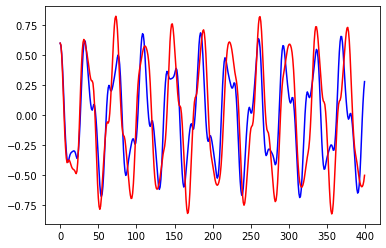

In [45]:
time_range = np.arange(0,400)
idx = 0
plt.plot(time_range, dp_data[time_range,idx], "blue")
#predict_data = [rsv.prediction(j)[idx] for j in time_range]
plt.plot(time_range,dp_pred_one[:,idx], "red")